In [2]:
from qiskit import BasicAer

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.core import Hamiltonian, TransformationType, QubitMappingType 
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

In [3]:
driver = PySCFDriver(atom='O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0',
                     unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()

print('Hartree-Fock energy: {}'.format(molecule.hf_energy))
print('Nuclear repulsion energy: {}'.format(molecule.nuclear_repulsion_energy))
print('Number of molecular orbitals: {}'.format(molecule.num_orbitals))
print('Number of alpha electrons: {}'.format(molecule.num_alpha))
print('Number of beta electrons: {}'.format(molecule.num_beta))

Hartree-Fock energy: -74.9629466565383
Nuclear repulsion energy: 9.193913160623385
Number of molecular orbitals: 7
Number of alpha electrons: 5
Number of beta electrons: 5


In [4]:
core = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                   two_qubit_reduction=True, freeze_core=True)
qubit_op, aux_ops = core.run(molecule)

print(qubit_op)

Representation: paulis, qubits: 10, size: 551


In [5]:
ee = ExactEigensolver(qubit_op, aux_operators=aux_ops)
algo_result = ee.run()
result = core.process_algorithm_result(algo_result)
for line in result[0]:
    print(line)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206272446428
  - computed part:      -23.544497240436
  - frozen energy part: -60.661775205992
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012359285805
  Measured:: Num particles: 8.000, S: 0.000, M: 0.00000
 
=== DIPOLE MOMENT ===
 
* Electronic dipole moment (a.u.): [0.0  1.57867263  0.0]
  - computed part:      [0.0  1.57778798  0.0]
  - frozen energy part: [0.0  0.00088465  0.0]
  - particle hole part: [0.0  0.0  0.0]
~ Nuclear dipole moment (a.u.): [0.0  2.21475902  0.0]
> Dipole moment (a.u.): [0.0  0.63608639  0.0]  Total: 0.63608639
               (debye): [0.0  1.61677018  0.0]  Total: 1.61677018


In [6]:
init_state = HartreeFock(num_qubits=qubit_op.num_qubits, 
                         num_orbitals=core._molecule_info['num_orbitals'],
                         num_particles=core._molecule_info['num_particles'],
                         qubit_mapping=core._qubit_mapping,
                         two_qubit_reduction=core._two_qubit_reduction)

var_form = UCCSD(num_qubits=qubit_op.num_qubits,
                 depth=1,
                 num_orbitals=core._molecule_info['num_orbitals'], 
                 num_particles=core._molecule_info['num_particles'],
                 qubit_mapping=core._qubit_mapping,
                 two_qubit_reduction=core._two_qubit_reduction, 
                 initial_state=init_state)

optimizer = SLSQP(maxiter=2500)

# setup backend on which we will run
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend=backend)

vqe = VQE(qubit_op, var_form, optimizer)
algo_result = vqe.run(quantum_instance)
lines, result = core.process_algorithm_result(algo_result)

print('Ground state energy: {}'.format(result['energy']))

for line in lines:
    print(line)

Ground state energy: -75.012258591145
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -84.206171751768
  - computed part:      -23.544396545776
  - frozen energy part: -60.661775205992
  - particle hole part: 0.0
~ Nuclear repulsion energy (Hartree): 9.193913160623
> Total ground state energy (Hartree): -75.012258591145
-75.012258591145


In [6]:
print('Actual VQE evaluations taken: {}'.format(result['algorithm_retvals']['eval_count']))

print('Actual VQE evaluations taken: {}'.format(algo_result['eval_count']))

Actual VQE evaluations taken: 666
Actual VQE evaluations taken: 666


In [23]:
import numpy as np
import pylab

h2o = 'H; O 1 1.08; H 2 {} 1 104.5'

distances = [x * 0.01 + 1.00 for x in range(17)]
energies = np.empty(len(distances))

for i, distance in enumerate(distances):
    print(i)
    driver = PySCFDriver(h2o.format(distance), basis='sto3g')
    qmolecule = driver.run()
    operator = Hamiltonian(transformation=TransformationType.FULL, qubit_mapping=QubitMappingType.PARITY, 
                           two_qubit_reduction=True, freeze_core=True)
    qubit_op, aux_ops = operator.run(qmolecule)
    optimizer = SLSQP(maxiter=2500)
    
    init_state = HartreeFock(num_qubits=qubit_op.num_qubits, 
                         num_orbitals=core._molecule_info['num_orbitals'],
                         num_particles=core._molecule_info['num_particles'],
                         qubit_mapping=core._qubit_mapping,
                         two_qubit_reduction=core._two_qubit_reduction)

    var_form = UCCSD(num_qubits=qubit_op.num_qubits,
                 depth=1,
                 num_orbitals=core._molecule_info['num_orbitals'], 
                 num_particles=core._molecule_info['num_particles'],
                 qubit_mapping=core._qubit_mapping,
                 two_qubit_reduction=core._two_qubit_reduction, 
                 initial_state=init_state)
    
    backend = BasicAer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend=backend)
    vqe = VQE(qubit_op, var_form, optimizer)
    algo_result = vqe.run(quantum_instance)
    lines, result = core.process_algorithm_result(algo_result)
    
    energies[i] = result['energy']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


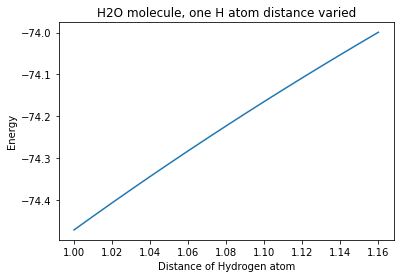

In [24]:
pylab.plot(distances, energies)
pylab.xlabel('Distance of Hydrogen atom')
pylab.ylabel('Energy')
pylab.title('H2O molecule, one H atom distance varied');

[0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0, 1.1, 1.2000000000000002, 1.3, 1.4000000000000001, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9000000000000001, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]
